In [429]:
#Testing how different test size effect the accuracy.
import torch
import torch.nn as nn
import torch.nn.functional as F


class ContrastiveLossNew(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLossNew, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - target) * torch.pow(euclidean_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        
        distance_positive = (anchor - positive).pow(2).sum(1)  #.pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + 1.5)#self.margin)
        
            
        return losses.mean() if size_average else losses.sum()
    
class SiameseNet(nn.Module):
    def __init__(self, input_size, embedding_size, dropout_prob=0.0, weight_decay=0.0):
        super(SiameseNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 196),
            nn.ReLU(),
            nn.Linear(196, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
#             nn.Linear(96, 64),
#             nn.ReLU(),
            nn.Linear(64, embedding_size),
#             nn.Sigmoid()  # Adding ReLU
            nn.BatchNorm1d(embedding_size)  # Adding BatchNorm1d for normalization
        )

        # Adding L2 regularization to linear layers
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)  # Initialize weights with He initialization
                nn.init.zeros_(layer.bias)  # Initialize biases with zeros
                self.weight_decay = weight_decay

    def forward_once(self, x):
        x = self.fc(x)
        return x / torch.norm(x, p=2, dim=1, keepdim=True)  # Normalize the output to have unit norm

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

In [430]:
import numpy as np
# sitting and reading
X = np.load('X_100.npy')
y = np.load('y_100.npy')

# # writing and sitting
# X = np.load('X_100_W_S.npy')
# y = np.load('y_100_W_S.npy')

# Step 1: Convert pandas DataFrames to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)  # Assuming y contains integer labels

X /=np.linalg.norm(X, axis=1, keepdims=True)

In [431]:
import torch

def create_XX(X, y, num_samples_per_iteration=10, num_iterations=300):
  # Get unique labels
  unique_labels = np.unique(y)

  # Initialize XX as an empty tensor to store all means
  XX = torch.empty((unique_labels.shape[0], num_iterations, X.shape[1]))

  # Loop through unique labels
  for i, label in enumerate(unique_labels):

    # Get indices of rows with current label
    label_indices = np.where(y == label)[0]

    # Check if there are enough rows for sampling
    if label_indices.shape[0] < num_samples_per_iteration:
        print(f"Warning: Label {label} has only {label_indices.shape[0]} rows. Sampling all available rows in each iteration.")

    # Loop for each iteration
    for j in range(num_iterations):
      if label_indices.shape[0] < num_samples_per_iteration:
          # Use all available rows if not enough for sampling
          selected_indices = label_indices
      else:
          # Randomly sample indices from rows with the same label
          selected_indices = torch.randint(0, label_indices.shape[0], (num_samples_per_iteration,))

      # Get the selected rows
      selected_rows = X[label_indices[selected_indices]]

      # Calculate mean of the selected rows
      mean_of_rows = torch.mean(selected_rows, dim=0)

      # Assign the mean to the corresponding row and iteration in XX
      XX[i, j] = mean_of_rows

  return XX

# Example usage
XX = create_XX(X, y, num_samples_per_iteration=20, num_iterations=600)
print(XX.shape)  # Should be (number of unique labels, number of iterations, number of features in X)

torch.Size([100, 600, 144])


In [432]:
def reshape_by_label(X):
    labels = []
    
    num_labels, num_samples, num_features = X.shape

    X_reshaped = X.view(num_labels, -1, num_features)  # -1 infers the size based on other dims

    # Create an empty tensor to store data points from all labels
    data_by_label = torch.empty((0, num_features))

    # Loop through each label
    for label in range(num_labels):
    # Get data points for the current label
        current_label_data = X_reshaped[label]

        # Stack the data points vertically (concatenate rows)
        data_by_label = torch.vstack((data_by_label, current_label_data))


        labels.extend([label] * num_samples)


    # Convert labels list to a tensor
    labels_tensor = torch.tensor(labels)

    return data_by_label, labels_tensor



X, y = reshape_by_label(XX)
y = y.unsqueeze(1)

In [433]:
test_mask = (y <= 100) & (y >= 50)

X_test = X[test_mask.any(dim=1)]
y_test = y[test_mask.any(dim=1)]


print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: torch.Size([30000, 144])
y_test: torch.Size([30000, 1])


In [434]:
test_mask = (y <= 50) & (y >= 0)

X_test = X[test_mask.any(dim=1)]
y_test = y[test_mask.any(dim=1)]


print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: torch.Size([30600, 144])
y_test: torch.Size([30600, 1])


In [435]:
input_size = 144
embedding_size = 32
siamese_net = SiameseNet(input_size, embedding_size)
siamese_net.load_state_dict(torch.load("siamese_model_U_50_A_20.pt"))  # Load saved state siamese_model_Write_Sitting

# siamese_net.load_state_dict(torch.load("siamese_model_Write_Sitting.pt")) 

siamese_net.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient tracking during evaluation
    outputs1, _ = siamese_net(X_test, X_test)

np.save('train_50_users_N_20_600.npy', y_test)
np.save('train_embeddings_50_users_N_20_600.npy', outputs1)

In [419]:
import numpy as np
from scipy.spatial.distance import pdist, squareform


y_train = np.load('test_50_users_N_20.npy')
X_train = np.load('test_embeddings_50_users_N_20.npy')

data = X_train
labels = y_train
# Step 1: Calculate the Euclidean distance matrix
distance_matrix = squareform(pdist(X_train, metric='euclidean'))
distance_matrix.shape

(15000, 15000)

In [378]:
y = y_train

# Step 2: Define a range of possible thresholds
thresholds = np.linspace(np.min(distance_matrix), np.max(distance_matrix), num=30)
# Lists to store the metrics
tpr_list = []
fpr_list = []
precision_list = []
recall_list = []
f1_score_list = []
tnr_list = []
tnr_tpr_list = []


# Function to calculate TP, FP, TN, FN for a given threshold
def calculate_confusion_matrix(distance_matrix, labels, threshold):
    similar_pairs = distance_matrix < threshold
    TP = FP = TN = FN = 0
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            if similar_pairs[i, j]:
                if labels[i] == labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                if labels[i] != labels[j]:
                    TN += 1
                else:
                    FN += 1
    return TP, FP, TN, FN

# Step 3: Evaluate performance metrics for each threshold
best_threshold = thresholds[0]
best_f1_score = 0

for threshold in thresholds:
    print(threshold)
    TP, FP, TN, FN = calculate_confusion_matrix(distance_matrix, y, threshold)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    tpr = recall  # TPR is the same as recall
    fpr = FP / (FP + TN) if FP + TN > 0 else 0
    
    tpr_list.append(100*tpr)
    fpr_list.append(100*fpr)
    precision_list.append(100*precision)
    recall_list.append(100*recall)
    f1_score_list.append(100*f1_score)
    tnr_list.append(100-100*fpr)
    tnr_tpr_list.append(100*(tpr+1-fpr)/2)
    
    
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_threshold = threshold

print(f'Best threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

0.0
0.06575197035626994
0.13150394071253987
0.1972559110688098
0.26300788142507975
0.3287598517813497
0.3945118221376196
0.46026379249388955
0.5260157628501595
0.5917677332064294
0.6575197035626994
0.7232716739189693
0.7890236442752392
0.8547756146315092
0.9205275849877791
0.9862795553440491
1.052031525700319
1.1177834960565889
1.1835354664128588
1.249287436769129
1.3150394071253988
1.3807913774816687
1.4465433478379386
1.5122953181942085
1.5780472885504784
1.6437992589067485
1.7095512292630184
1.7753031996192883
1.8410551699755582
1.9068071403318283
Best threshold: 0.7232716739189693
Best F1 Score: 0.779029457383502


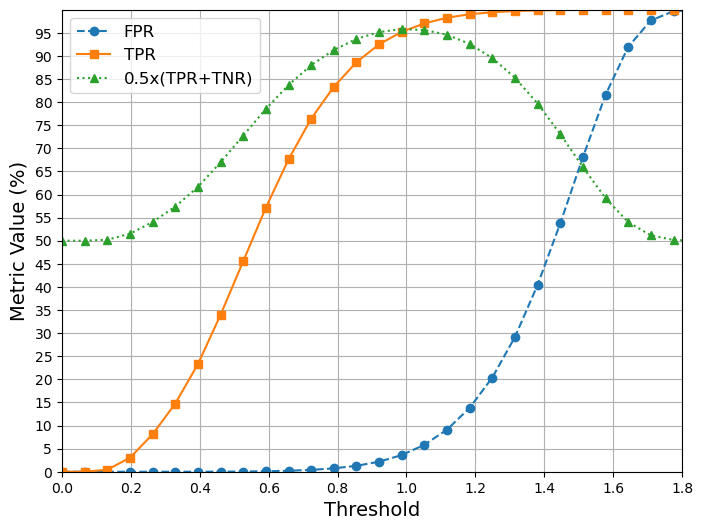

In [379]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# plt.plot(thresholds, tpr_list, label='True Positive Rate (TPR)')
plt.plot(thresholds, fpr_list, label='FPR', linestyle='--', marker='o')  # dashed line with circle markers
# plt.plot(thresholds, precision_list, label='Precision')  # Commented out as per your previous comment
plt.plot(thresholds, recall_list, label='TPR', linestyle='-', marker='s')  # solid line with square markers
plt.plot(thresholds, tnr_tpr_list, label='0.5x(TPR+TNR)', linestyle='dotted', marker='^')  # dotted line with triangle markers

# plt.plot(thresholds, f1_score_list, label='F1 Score')
plt.xlabel('Threshold',  fontsize = 14)
plt.ylabel('Metric Value (%)', fontsize = 14)
# plt.title('Metrics vs. Threshold')
plt.legend(fontsize = 12)
plt.grid(True)
plt.ylim(bottom=0, top=100)  # Adjust limits as needed
plt.xlim(left=0, right=1.8)  # Adjust limits as needed
# plt.xticks(np.arange(0, 1.8, 1))  # Major ticks every 1 unit on x-axis
plt.yticks(np.arange(0, 100, 5))  # Major ticks every 0.2 unit on y-axis
plt.show()

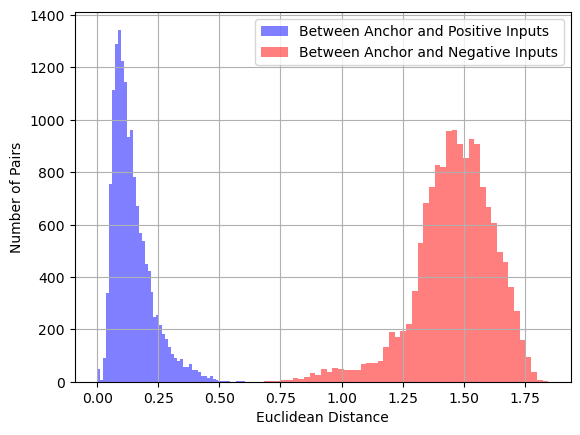

In [420]:
import numpy as np
import matplotlib.pyplot as plt

O =[]
A = []

for i in range(0,50):

    user_distances = distance_matrix[i,:]
    self_distances = user_distances[0:300]
    O.append(self_distances)

    mask = np.ones(len(user_distances), dtype=bool)  
    mask[0:300] = False  
    other_user_distances = user_distances[mask]  
    A.append(other_user_distances)

# Once the loop finishes, convert the list to a NumPy array
A = np.concatenate(A) 
O = np.concatenate(O) 

random_indices = np.random.choice(A.shape[0], size=15000, replace=False)

# Extract the 100 random elements from A
A = A[random_indices]


plt.hist(O, bins=50, alpha=0.5, color='blue', label='Between Anchor and Positive Inputs')

# Plot histogram for negative distances
plt.hist(A, bins=50, alpha=0.5, color='red', label='Between Anchor and Negative Inputs')


plt.xlabel('Euclidean Distance')
plt.ylabel('Number of Pairs')
# plt.title('1st User: Self vs. Other User Distances Distribution')
plt.legend()
plt.grid(True)
plt.show()
